# The Markov Chain Monte Carlo (MCMC) method

This is an iterative sampling method based on the familiar Baye's theorem, given by:
$p(y,|x)=\frac{p(x|y)p(y)}{p(y)}$

The basic algorithm is as follows:
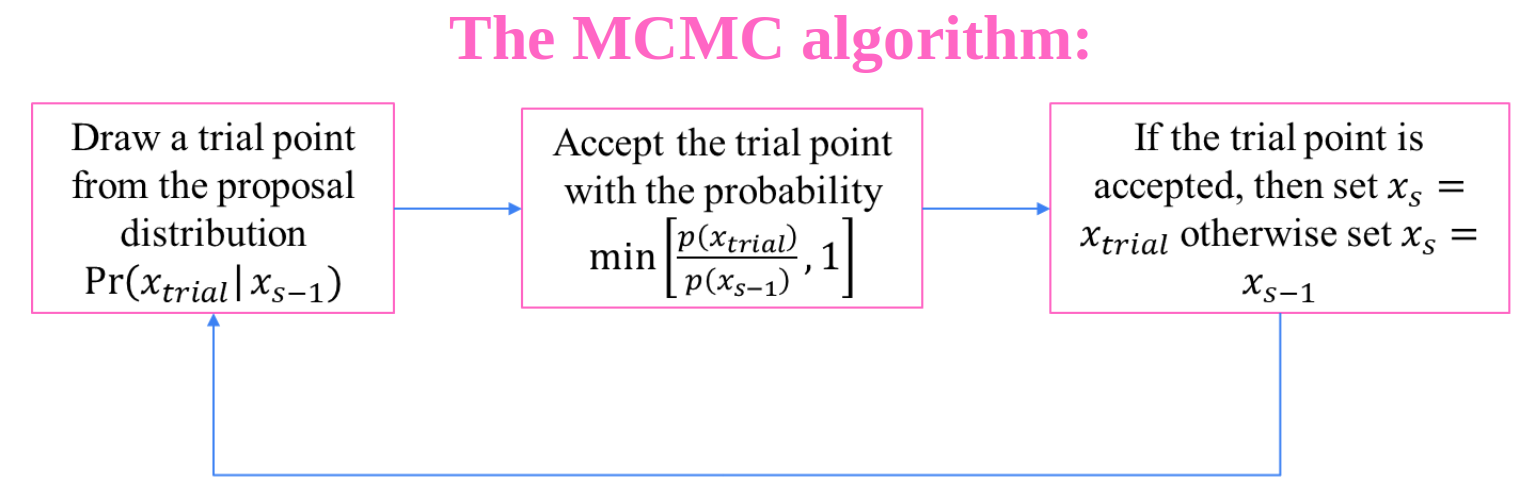


The code below is an implementation of MCMC that follows from first principles and uses something known as the Metropolis Hastings Algorithm. To read more about Markov Chains, MCMC, and Metropolis Hastings, refer to the resources below:

1. [Markov Chains](https://brilliant.org/wiki/markov-chains/#:~:text=A%20Markov%20chain%20is%20a,possible%20future%20states%20are%20fixed.)
2. MCMC [Source 1](https://machinelearningmastery.com/markov-chain-monte-carlo-for-probability/) [Source 2](https://towardsdatascience.com/monte-carlo-markov-chain-mcmc-explained-94e3a6c8de11) [Source 3](https://link.springer.com/article/10.3758/s13423-016-1015-8)
3. [Metropolis Hastings Algorithm](https://www.coursera.org/lecture/probabilistic-graphical-models-2-inference/metropolis-hastings-algorithm-UPVWC)
4. [Detailed problem demonstrated below](https://www.imperial.ac.uk/media/imperial-college/research-centres-and-groups/astrophysics/public/icic/data-analysis-workshop/2018/SN-MCMC-project-2018.pdf)

In this case, we use the following formulation of Likelihood:
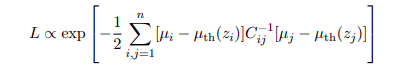

## Now the actual code:

## A. The setup
### 1. Importing required libraries

In [1]:
import numpy as np
import numpy.linalg as npl
import matplotlib.pyplot as plt

### 2. Defining some important constants (for this particular problem)
Modify accordingly if using custom data.

In [2]:
c=3*10**8
ns=10000         #number of samples
par=2           #number of parameters
snb=31          #number of bins in the SN data

### 3. Assuming gaussian distribution and same standard deviations for both omega matter and h

In [3]:
sigo=0.01         #standard deviation for omega matter
sigh=0.01           #standard deviation of h

### 4. Calculating the inverse covariance matrix 

In this case I will be using some Astrophysical data (supernova Ia data to calculate some cosmological parameters, a classic problem in this domain). If you want to use your own data, you may customize the following 2 cells accordingly.

In [4]:
#storing the covarient matrix, reshaping it to a square matrix and taking inverse
C=np.loadtxt('data/jla_mub_covmatrix.txt',skiprows=1)
C=np.reshape(C,(snb,snb))
cinv=npl.inv(C)          #inverse of C

### 5. Reading in redshift and distance modulous data

In [5]:
z=np.loadtxt('data/jla_mub_0.txt',skiprows=1,usecols=0)
M=np.loadtxt('data/jla_mub_0.txt',skiprows=1,usecols=1)

### 5. Defining an empty list for storage

1st column holds omega matter, 2nd column holds h and third column holds the loglikelihood

In [6]:
ar=np.empty([ns,par+1])

### 6. Defining all the necessary functions
Modify if using custom data. A glossary for this particular use case is as follows:

|Function name |What it does|
|:-|:-|
|eta()| Defines the variable $\eta$ as 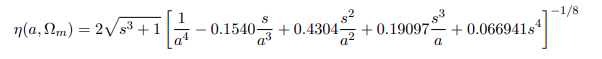 (given in the problem|
|Dl()| Luminosity Distance $D_L$ as 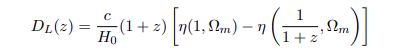 |
|mu()| Distance Modulus $\mu$, generally given by $\mu = m-M$, defined here as 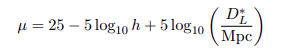|
|likelihood()| Defines the LogLikelihood according to the likelihood definition above|

In [7]:
def eta(a,om):                      #eta
    if om>=0.9999:                  #neglecting unphysical cases
        om=0.9999
    elif om<=0.0:
        om=0.000001
    else:
        pass
    s=((1.0-om)/om)**(1.0/3.0)
    n= 2.0*(np.sqrt((s*s*s)+1))*(((a**(-4.0))-(0.1540*s*(a**(-3.0)))+(0.4304*s*s*(a**(-2.0)))+(0.19097*s*s*s*(a**(-1.0)))+(0.066941*s*s*s*s)))**(-1.0/8.0)
    return n


def Dl(z,om):                          #luminosity distance
    eta1=eta(1,om)
    eta2=eta(1/(1+z),om)
    d=(3000.0*(1+z))*(eta1-eta2)
    return d


def mu(z,om,h):                     #distance modulus (theoretical)                
    d=Dl(z,om)
    m=25-(5*np.log10(h))+(5*np.log10(d))
    return m

#log likelihood function
diff=np.empty(snb)  #temporary variable to store difference between observed distance modulus and theoretical distance modulus
def likelihood(om,h,z,M):                   #natural log likelihood function
    if om<=0.0 or h<=0.0:                   #we know they must be positive so removing unphysical conditions
        l=-1.e100
    else:
        for i in range(snb):
            diff[i]=M[i]-mu(z[i],om,h)
        dt=np.dot(cinv,diff)
        l=-0.5*np.dot(np.transpose(diff),dt)      #taking dot products
    return l                                      #l is ln(L)

## B. MCMC
### 9. Initialising

In [8]:
ar[0,0]=np.random.uniform() 
ar[0,1]=np.random.uniform()
ar[0,2]=likelihood(ar[0,0],ar[0,1],z,M)
accn=0                                      #number of sample points accepted

### 10. Sampling and the Metropolis Hastings algorithm

In [9]:
%%time
#Sampling:
for i in range(1,ns):
    lpre=ar[i-1,2]
    omnext=np.random.normal(ar[i-1,0],sigo)     #sampling random numbers from normal distribution
    hnext=np.random.normal(ar[i-1,1],sigh)
    lnext=likelihood(omnext,hnext,z,M)
#Metropolis Hastings Algorithm: will accept if likelihood increases or will pass
    if lnext>=lpre:
        ar[i,0]=omnext
        ar[i,1]=hnext
        ar[i,2]=lnext
        accn=accn+1
        #print("Accepted with higher likelihood.")
    else:
        x=np.random.uniform()
        if (lnext-lpre)>np.log(x):                      #Will accept with a lower likelihood but within a random limit
            ar[i,0]=omnext
            ar[i,1]=hnext
            ar[i,2]=lnext
            accn=accn+1
            #print("Accepted with lesser likelihood.")
        else:                                           #Rejecting the values that don't satisfy either conditions and storing previous values as the current value
            ar[i,0]=ar[i-1,0]
            ar[i,1]=ar[i-1,1]
            ar[i,2]=lpre
            #print("rejected")
print("Done sampling!")

Done sampling!
CPU times: user 5.34 s, sys: 404 ms, total: 5.74 s
Wall time: 5.25 s


### 11. Burn-in (10%)

In [10]:
r=ns//10

### 12. Calculating some values of statistical importance and displaying

In [11]:
omm=np.mean(ar[r:,0])         #mean or estimated value of omega matter
hm=np.mean(ar[r:,1])          #mean or estimated value of h
omsd=np.std(ar[r:,0])         #standard deviation in omega matter
hsd=np.std(ar[r:,1])          #standard deviation in h
accr=(accn*100)/ns            #acceptance ratio
print('Estimated value of omega matter is:'+str(omm))
print('Estimated standard deviation in omega matter is:'+str(omsd))
print('estimated value of scaling factor h is:'+str(hm))
print('Estimated standard deviation in scaling factor is:'+str(hsd))
print('Percentage of samples accepted (acceptance ratio) is:'+str(accr))

Estimated value of omega matter is:0.29714863706822875
Estimated standard deviation in omega matter is:0.02887791010056915
estimated value of scaling factor h is:0.7028319971708367
Estimated standard deviation in scaling factor is:0.006943013949422756
Percentage of samples accepted (acceptance ratio) is:51.1


### 13. Calculating the theoretical (true in this case) using Cosmological principles

In [12]:
yth=np.empty(snb)
for i in range(snb):
    yth[i]=mu(z[i],omm,hm)

### 14. Visualizing Everything

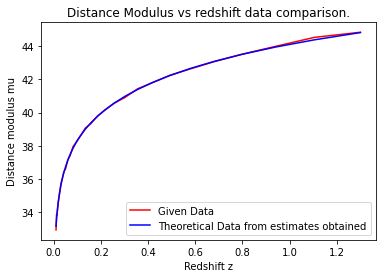

In [13]:
#1. Plotting the given data and comparing with theoretical data
plt.figure(1)
plt.xlabel('Redshift z')
plt.ylabel('Distance modulus mu')
plt.title('Distance Modulus vs redshift data comparison.')
plt.plot(z,M,c='red',label="Given Data")
plt.plot(z,yth,c='blue',label="Theoretical Data from estimates obtained")
plt.legend()
plt.show()

Text(0, 0.5, 'Scaling Factor h')

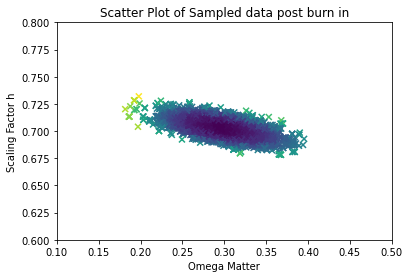

In [14]:
#2. Scatter plot:
plt.figure(2)
plt.xlabel('Redshift z')
plt.ylabel('Given distance modulus mu')
plt.title('Scatter Plot of Sampled data post burn in')
plt.scatter(ar[r:,0],ar[r:,1],c=-ar[r:,2],marker='x')
plt.xlim(0.1,0.5)
plt.ylim(0.6,0.8)
plt.xlabel('Omega Matter')
plt.ylabel('Scaling Factor h')

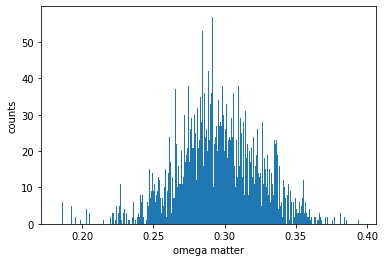

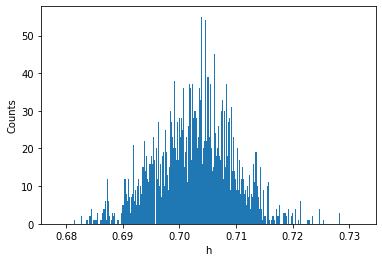

In [15]:
#3: histograms
plt.figure(3)
plt.xlabel('omega matter')
plt.ylabel('counts')
plt.hist(ar[r:,0],bins=1000)
plt.figure(4)
plt.xlabel("h")
plt.ylabel("Counts")
plt.hist(ar[r:,1],bins=1000)
plt.show()